# Load imports and create directories

In [1]:
from ROOT import (TCanvas, TPad, TFile, TPaveLabel, 
                  TPaveText, gROOT, TH1F, TH1D, TLegend, 
                  gStyle, TH2F, TChain, TGraphErrors, TText, gPad, gROOT, TTree)
from array import array
import datetime
import numpy as np

np.random.seed(42)
        
from keras.models import Sequential, Model
from keras.layers import Concatenate, Dense, LSTM, Input, concatenate, SimpleRNN, GRU, Masking, Lambda, Reshape, Dropout, RNN
from keras.optimizers import Adagrad, SGD, RMSprop, Adam

from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout, LeakyReLU, LSTM, Conv1D, SimpleRNN, Concatenate
from keras import optimizers
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score
import keras.backend as K
import pickle
#import seaborn as sns

TODAY = datetime.datetime.now().strftime('%Y-%m-%d')

def init_dirs():
    import datetime, os
    for _dir in ["plots", "models"]:
        today_dir = os.path.join(_dir, TODAY)
        if not os.path.isdir(today_dir):
            os.makedirs(today_dir)
            
#init_dirs()
from sklearn import preprocessing
from keras import regularizers
import tensorflow as tf

Welcome to JupyROOT 6.14/06


Using TensorFlow backend.


## define features and cuts

In [2]:
# all methods here
MASS_FEATURE_INDEX = 0
def prep_mass(xbtrain, xstrain, norm=None):
    np.random.seed(42)
    new = xbtrain.copy()
    sump = sum(xstrain[:,-1])
    for d in new:
        mass = np.random.choice(xstrain[:,MASS_FEATURE_INDEX], p=1/sump*xstrain[:,-1])
        if norm:
            mass = mass / norm
        d[MASS_FEATURE_INDEX] = mass
    return new

def unison_shuffled_copies(*arr):
    assert all(len(a) for a in arr)
    p = np.random.permutation(len(arr[0]))
    return (a[p] for a in arr)

# Load weights for prescaling (you may or may not need this)

Rescale the samples according to their cross section.

In [3]:
Xsec_dict={5:6.76E-03, 7:5.33E-03, 9:4.40E-03, 11:3.71E-03, 13:3.18E-03, 15:3.59E-03, 17:3.86E-03, 19:4.02E-03, 23:5.81E-03, 27:6.67E-03, 31:6.71E-03, 35:9.60E-03, 39:1.07E-02, 45:7.99E-03, 51:5.20E-03, 57:6.36E-03, 63:8.33E-03, 69:9.77E-03, 75:1.17E-02}

def getweight(wt, mass=5):
    totalWt = sum(wt)
    wt = Xsec_dict[mass]*wt/totalWt*(1000/0.12369)
    return wt

def norweight(wt, norm=1091):
    totalWt = sum(wt)
    wt = norm*wt/totalWt
    return wt

def get_part_feature(xtrain):
    #nf = [0,1,2,3,4,5,6,7,8,11,12,13,14,15,16,17,18,19]
    nf = [0,1,2,3,4,5,6,7,8,11,12,13,14,16,17,18,19]
    xtrain = xtrain[:,nf]
    return xtrain


# Start training
## setup datasets for training and testing
### Signal

In [22]:
## ===========================================================================
# Load and sum signal dataset
xs_train = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below180/UnscaledData/train/tree_{}GeV.npy'.format(42))
xs_train[:,-1] = norweight(xs_train[:,-1])
xs_val = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below180/UnscaledData/Validation/tree_{}GeV.npy'.format(42))
xs_test = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below180/UnscaledData/test/tree_{}GeV.npy'.format(42))

#msamp2 = [7,9,11,13,15,17,19,23,27,31,35,39,45,51,57,63,69,75]
msamp2 = [45,48,51,54,57,60,63,66,69,72,75]
for mass in msamp2:
    ### for signal
    xs_train_add = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below180/UnscaledData/train/tree_{}GeV.npy'.format(mass))
    xs_train_add[:,-1] = norweight(xs_train_add[:,-1])
    xs_train = np.concatenate((xs_train,xs_train_add))
    xs_val_add = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below180/UnscaledData/Validation/tree_{}GeV.npy'.format(mass))
    xs_val = np.concatenate((xs_val,xs_val_add))
    xs_test_add = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below180/UnscaledData/test/tree_{}GeV.npy'.format(mass))
    xs_test = np.concatenate((xs_test,xs_test_add))

## =============================================================================
# Load and sum background dataset
xb_train = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below180/UnscaledData/train/tree_qqZZ.npy')
xb_val = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below180/UnscaledData/Validation/tree_qqZZ.npy')
xb_test = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below180/UnscaledData/test/tree_qqZZ.npy')
bkgset = ['ggZZ', 'ggZZ_low']
#bkgset = ['ggZZ_low']
for bk in bkgset:
    xb_train_add = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below180/UnscaledData/train/tree_{}.npy'.format(bk))
    xb_train = np.concatenate((xb_train,xb_train_add))
    xb_val_add = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below180/UnscaledData/Validation/tree_{}.npy'.format(bk))
    xb_val = np.concatenate((xb_val,xb_val_add))
    xb_test_add = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below180/UnscaledData/test/tree_{}.npy'.format(bk))
    xb_test = np.concatenate((xb_test,xb_test_add))   

xb_train[:,-1] = norweight(xb_train[:,-1], norm=12000)
### randomly reset the mass parameter for training bkg
xb_train = prep_mass(xb_train, xs_train, norm=None)
ys_train = np.ones(len(xs_train))
yb_train = np.zeros(len(xb_train))
xcomb_train = np.concatenate((xs_train, xb_train))
ycomb_train  = np.concatenate((ys_train, yb_train))
print("Signal:", sum(xs_train[:,-1]), "background:", sum(xb_train[:,-1]), "combined:", sum(xcomb_train[:,-1]))

## load cross validation data
ys_val = np.ones(len(xs_val))
yb_val = np.zeros(len(xb_val))
xcomb_val = np.concatenate((xs_val, xb_val))
ycomb_val = np.concatenate((ys_val, yb_val))

## load test data
ys_test = np.ones(len(xs_test))
yb_test = np.zeros(len(xb_test))
xcomb_test = np.concatenate((xs_test, xb_test))
ycomb_test = np.concatenate((ys_test, yb_test))

# Randomlize the order of training data using split function
x1, xcomb_train, y1, ycomb_train = train_test_split(
        xcomb_train, ycomb_train, test_size=0.999999, random_state=1234, shuffle=True)
x1, xcomb_val, y1, ycomb_val = train_test_split(
        xcomb_val, ycomb_val, test_size=0.999999, random_state=1234, shuffle=True)
x1, xcomb_test, y1, ycomb_test = train_test_split(
        xcomb_test, ycomb_test, test_size=0.999999, random_state=1234, shuffle=True)

# Define the weight and features for training
wt_train = xcomb_train[:,-1]
wt_test = xcomb_test[:,-1]
wt_val = xcomb_val[:,-1]
xcomb_train = get_part_feature(xcomb_train)
xcomb_test = get_part_feature(xcomb_test)
xcomb_val = get_part_feature(xcomb_val)

print ("Training data shape:", xcomb_train.shape, xs_train.shape, xb_train.shape)
print ("Validation data shape:", xcomb_val.shape, xs_val.shape, xb_val.shape)
print ("Testing data shape:", xcomb_test.shape, xs_test.shape, xb_test.shape)

Signal: 13091.999999999964 background: 12000.000000000013 combined: 25092.000000000022
Training data shape: (54643, 17) (38032, 24) (16611, 24)
Validation data shape: (18217, 17) (12679, 24) (5538, 24)
Testing data shape: (18223, 17) (12684, 24) (5539, 24)


## Making some plots

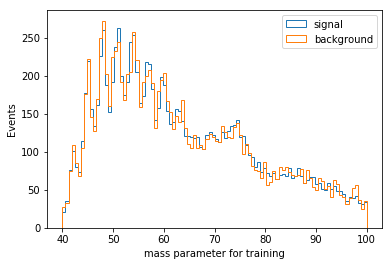

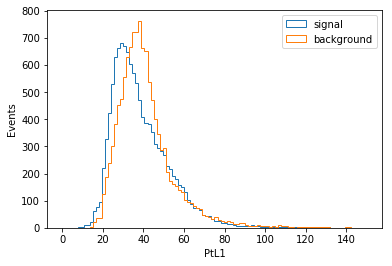

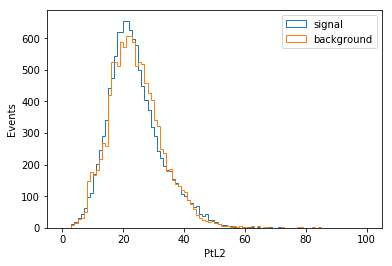

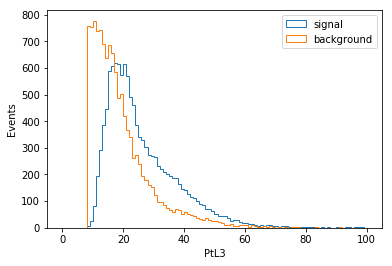

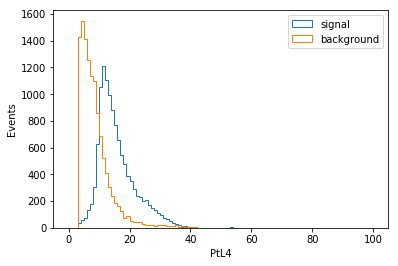

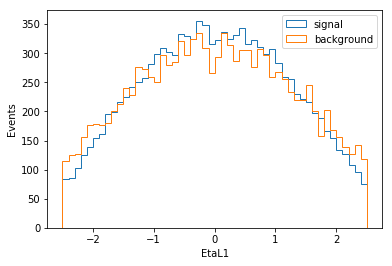

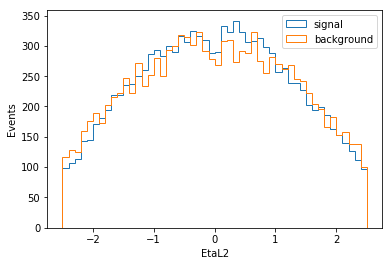

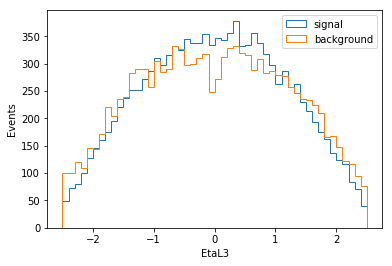

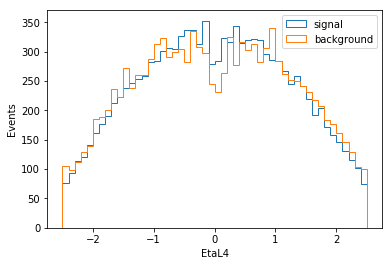

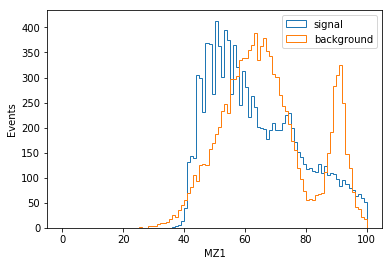

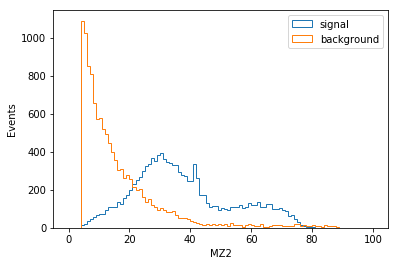

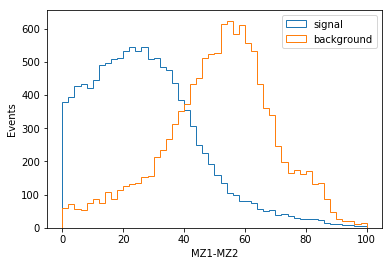

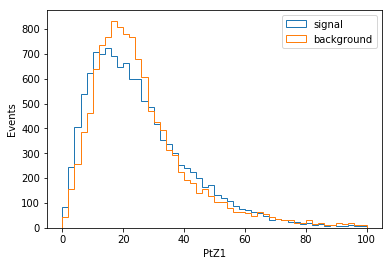

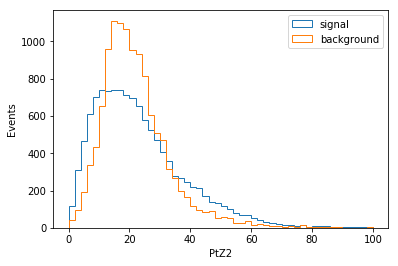

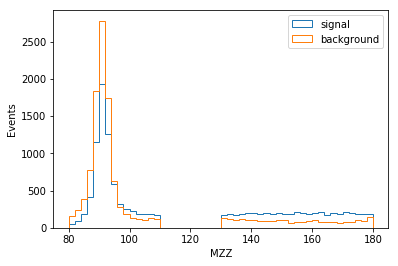

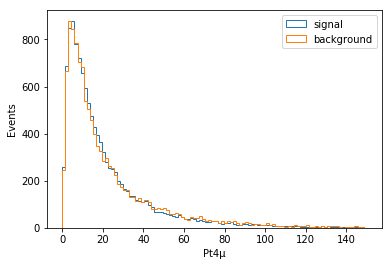

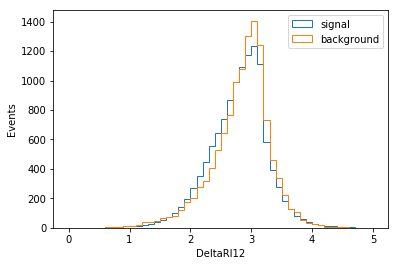

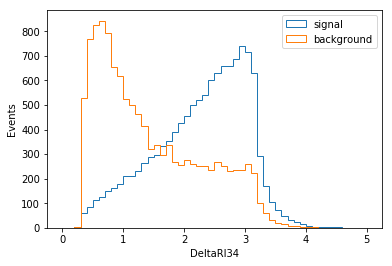

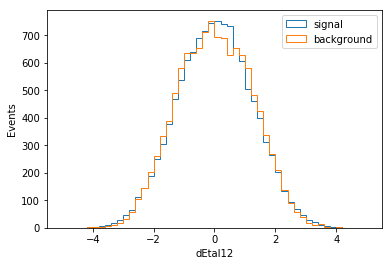

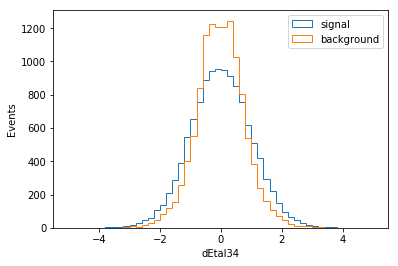

In [9]:
import matplotlib.pyplot as plt
###################################################################
### plot the real variables before scale
######################################################################
plt.figure(figsize=(6, 4))
plt.hist(xs_train[:,0], bins=100, weights=xs_train[:,-1], histtype='step', label='signal', range=(40,100))
plt.hist(xb_train[:,0], bins=100, weights=xb_train[:,-1], histtype='step', label='background', range=(40,100))
plt.legend(prop={'size': 10})
plt.xlabel("mass parameter for training")
plt.ylabel("Events")
plt.savefig("/Users/zhuheling/ML/keras/example_hep/myTest/plots/hM_mass_train.pdf", format='pdf')
plt.show()

## PtL1/2/3/4
plt.figure(figsize=(6, 4))
plt.hist(xs_train[:,1], bins=100, weights=xs_train[:,-1], histtype='step', label='signal', range=(0,150))
plt.hist(xb_train[:,1], bins=100, weights=xb_train[:,-1], histtype='step', label='background', range=(0,150))
plt.legend(prop={'size': 10})
plt.xlabel("PtL1")
plt.ylabel("Events")
plt.savefig("/Users/zhuheling/ML/keras/example_hep/myTest/plots/hM_PtL1.pdf")
plt.show()

plt.figure(figsize=(6, 4))
plt.hist(xs_train[:,2], bins=100, weights=xs_train[:,-1], histtype='step', label='signal', range=(0,100))
plt.hist(xb_train[:,2], bins=100, weights=xb_train[:,-1], histtype='step', label='background', range=(0,100))
plt.legend(prop={'size': 10})
plt.xlabel("PtL2")
plt.ylabel("Events")
plt.savefig("/Users/zhuheling/ML/keras/example_hep/myTest/plots/kine/hM_PtL2.pdf")
plt.show()

plt.figure(figsize=(6, 4))
plt.hist(xs_train[:,3], bins=100, weights=xs_train[:,-1], histtype='step', label='signal', range=(0,100))
plt.hist(xb_train[:,3], bins=100, weights=xb_train[:,-1], histtype='step', label='background', range=(0,100))
plt.legend(prop={'size': 10})
plt.xlabel("PtL3")
plt.ylabel("Events")
plt.savefig("/Users/zhuheling/ML/keras/example_hep/myTest/plots/kine/hM_PtL3.pdf")
plt.show()

plt.figure(figsize=(6, 4))
plt.hist(xs_train[:,4], bins=100, weights=xs_train[:,-1], histtype='step', label='signal', range=(0,100))
plt.hist(xb_train[:,4], bins=100, weights=xb_train[:,-1], histtype='step', label='background', range=(0,100))
plt.legend(prop={'size': 10})
plt.xlabel("PtL4")
plt.ylabel("Events")
plt.savefig("/Users/zhuheling/ML/keras/example_hep/myTest/plots/kine/hM_PtL4.pdf")
plt.show()

## EtaL1/2/3/4
plt.figure(figsize=(6, 4))
plt.hist(xs_train[:,5], bins=50, weights=xs_train[:,-1], histtype='step', label='signal', range=(-2.5,2.5))
plt.hist(xb_train[:,5], bins=50, weights=xb_train[:,-1], histtype='step', label='background', range=(-2.5,2.5))
plt.legend(prop={'size': 10})
plt.xlabel("EtaL1")
plt.ylabel("Events")
plt.savefig("/Users/zhuheling/ML/keras/example_hep/myTest/plots/kine/hM_EtaL1.pdf")
plt.show()

plt.figure(figsize=(6, 4))
plt.hist(xs_train[:,6], bins=50, weights=xs_train[:,-1], histtype='step', label='signal', range=(-2.5,2.5))
plt.hist(xb_train[:,6], bins=50, weights=xb_train[:,-1], histtype='step', label='background', range=(-2.5,2.5))
plt.legend(prop={'size': 10})
plt.xlabel("EtaL2")
plt.ylabel("Events")
plt.savefig("/Users/zhuheling/ML/keras/example_hep/myTest/plots/kine/hM_EtaL2.pdf")
plt.show()

plt.figure(figsize=(6, 4))
plt.hist(xs_train[:,7], bins=50, weights=xs_train[:,-1], histtype='step', label='signal', range=(-2.5,2.5))
plt.hist(xb_train[:,7], bins=50, weights=xb_train[:,-1], histtype='step', label='background', range=(-2.5,2.5))
plt.legend(prop={'size': 10})
plt.xlabel("EtaL3")
plt.ylabel("Events")
plt.savefig("/Users/zhuheling/ML/keras/example_hep/myTest/plots/kine/hM_EtaL3.pdf")
plt.show()

plt.figure(figsize=(6, 4))
plt.hist(xs_train[:,8], bins=50, weights=xs_train[:,-1], histtype='step', label='signal', range=(-2.5,2.5))
plt.hist(xb_train[:,8], bins=50, weights=xb_train[:,-1], histtype='step', label='background', range=(-2.5,2.5))
plt.legend(prop={'size': 10})
plt.xlabel("EtaL4")
plt.ylabel("Events")
plt.savefig("/Users/zhuheling/ML/keras/example_hep/myTest/plots/kine/hM_EtaL4.pdf")
plt.show()

## MZ1
plt.figure(figsize=(6, 4))
plt.hist(xs_train[:,9], bins=100, weights=xs_train[:,-1], histtype='step', label='signal', range=(0,100))
plt.hist(xb_train[:,9], bins=100, weights=xb_train[:,-1], histtype='step', label='background', range=(0,100))
plt.legend(prop={'size': 10})
plt.xlabel("MZ1")
plt.ylabel("Events")
plt.savefig("/Users/zhuheling/ML/keras/example_hep/myTest/plots/kine/hM_MZ1.pdf")
plt.show()

## MZ2
plt.figure(figsize=(6, 4))
plt.hist(xs_train[:,10], bins=100, weights=xs_train[:,-1], histtype='step', label='signal', range=(0,100))
plt.hist(xb_train[:,10], bins=100, weights=xb_train[:,-1], histtype='step', label='background', range=(0,100))
plt.legend(prop={'size': 10})
plt.xlabel("MZ2")
plt.ylabel("Events")
plt.savefig("/Users/zhuheling/ML/keras/example_hep/myTest/plots/kine/hM_MZ2.pdf")
plt.show()

## MZ1-MZ2
plt.figure(figsize=(6, 4))
plt.hist(xs_train[:,11], bins=50, weights=xs_train[:,-1], histtype='step', label='signal', range=(0,100))
plt.hist(xb_train[:,11], bins=50, weights=xb_train[:,-1], histtype='step', label='background', range=(0,100))
plt.legend(prop={'size': 10})
plt.xlabel("MZ1-MZ2")
plt.ylabel("Events")
plt.savefig("/Users/zhuheling/ML/keras/example_hep/myTest/plots/kine/hM_MZ1_MZ2.pdf")
plt.show()

## PtZ1
plt.figure(figsize=(6, 4))
plt.hist(xs_train[:,12], bins=50, weights=xs_train[:,-1], histtype='step', label='signal', range=(0,100))
plt.hist(xb_train[:,12], bins=50, weights=xb_train[:,-1], histtype='step', label='background', range=(0,100))
plt.legend(prop={'size': 10})
plt.xlabel("PtZ1")
plt.ylabel("Events")
plt.savefig("/Users/zhuheling/ML/keras/example_hep/myTest/plots/kine/hM_PtZ1.pdf")
plt.show()

## PtZ2
plt.figure(figsize=(6, 4))
plt.hist(xs_train[:,13], bins=50, weights=xs_train[:,-1], histtype='step', label='signal', range=(0,100))
plt.hist(xb_train[:,13], bins=50, weights=xb_train[:,-1], histtype='step', label='background', range=(0,100))
plt.legend(prop={'size': 10})
plt.xlabel("PtZ2")
plt.ylabel("Events")
plt.savefig("/Users/zhuheling/ML/keras/example_hep/myTest/plots/kine/hM_PtZ2.pdf")
plt.show()

## MZZ
plt.figure(figsize=(6, 4))
plt.hist(xs_train[:,14], bins=50, weights=xs_train[:,-1], histtype='step', label='signal', range=(80,180))
plt.hist(xb_train[:,14], bins=50, weights=xb_train[:,-1], histtype='step', label='background', range=(80,180))
plt.legend(prop={'size': 10})
plt.xlabel("MZZ")
plt.ylabel("Events")
plt.savefig("/Users/zhuheling/ML/keras/example_hep/myTest/plots/kine/hM_MZZ.pdf")
plt.show()

## PtZZ
plt.figure(figsize=(6, 4))
plt.hist(xs_train[:,15], bins=100, weights=xs_train[:,-1], histtype='step', label='signal', range=(0,150))
plt.hist(xb_train[:,15], bins=100, weights=xb_train[:,-1], histtype='step', label='background', range=(0,150))
plt.legend(prop={'size': 10})
plt.xlabel("Pt4μ")
plt.ylabel("Events")
plt.savefig("/Users/zhuheling/ML/keras/example_hep/myTest/plots/kine/hM_PtZZ.pdf")
plt.show()

## DeltaRl12/34
plt.figure(figsize=(6, 4))
plt.hist(xs_train[:,16], bins=50, weights=xs_train[:,-1], histtype='step', label='signal', range=(0,5))
plt.hist(xb_train[:,16], bins=50, weights=xb_train[:,-1], histtype='step', label='background', range=(0,5))
plt.legend(prop={'size': 10})
plt.xlabel("DeltaRl12")
plt.ylabel("Events")
plt.savefig("/Users/zhuheling/ML/keras/example_hep/myTest/plots/kine/hM_DeltaRl12.pdf")
plt.show()

plt.figure(figsize=(6, 4))
plt.hist(xs_train[:,17], bins=50, weights=xs_train[:,-1], histtype='step', label='signal', range=(0,5))
plt.hist(xb_train[:,17], bins=50, weights=xb_train[:,-1], histtype='step', label='background', range=(0,5))
plt.legend(prop={'size': 10})
plt.xlabel("DeltaRl34")
plt.ylabel("Events")
plt.savefig("/Users/zhuheling/ML/keras/example_hep/myTest/plots/kine/hM_DeltaRl34.pdf")
plt.show()

## dEtal12/34
plt.figure(figsize=(6, 4))
plt.hist(xs_train[:,18], bins=50, weights=xs_train[:,-1], histtype='step', label='signal', range=(-5,5))
plt.hist(xb_train[:,18], bins=50, weights=xb_train[:,-1], histtype='step', label='background', range=(-5,5))
plt.legend(prop={'size': 10})
plt.xlabel("dEtal12")
plt.ylabel("Events")
plt.savefig("/Users/zhuheling/ML/keras/example_hep/myTest/plots/kine/hM_dEtal12.pdf")
plt.show()

plt.figure(figsize=(6, 4))
plt.hist(xs_train[:,19], bins=50, weights=xs_train[:,-1], histtype='step', label='signal', range=(-5,5))
plt.hist(xb_train[:,19], bins=50, weights=xb_train[:,-1], histtype='step', label='background', range=(-5,5))
plt.legend(prop={'size': 10})
plt.xlabel("dEtal34")
plt.ylabel("Events")
plt.savefig("/Users/zhuheling/ML/keras/example_hep/myTest/plots/kine/hM_dEtal34.pdf")
plt.show()



# Setting training

In [11]:
def create_adv_model(activation='relu', loss='mse', neurons=64, dropout=0.05, lr=1e-3, reg=None,
                    optimiser='adagrad', use_costheta=False):
    
    def split_mu_input(_X):
        return _X[:,1:9]
    
    def split_pair_input(_X):
        import tensorflow as tf
        #return tf.gather_nd(_X, [0,9,10,11,12,13,14,15,16,17])
        indices = tf.constant([0,9,10,11,12,13,14,15,16,17])
        selected = tf.gather(tf.transpose(_X, [1, 0]), indices)
        selected_t = tf.transpose(selected, [1, 0]) 
        return selected_t
    
    X = Input(shape=(18, ), name='X')
    #print(X)
    mlp_input = Lambda(split_pair_input, name='mlp_input')(X)
    first_dense = Dense(100, name='first_dense', activation=activation, kernel_regularizer=reg)(mlp_input)
    dropout_mlp1 = Dropout(dropout, name='dropout_mlp1')(first_dense)
    second_dense = Dense(90, name='second_dense', activation=activation, kernel_regularizer=reg)(dropout_mlp1)
    dropout_mlp2 = Dropout(dropout, name='dropout_mlp2')(second_dense)
    third_dense = Dense(64, name='third_dense', activation=activation, kernel_regularizer=reg)(dropout_mlp2)
    mlp_out = Dense(50, name='mlp_out', activation=activation, kernel_regularizer=reg)(third_dense)
    
    pair_input = Lambda(split_mu_input, name='pair_input')(X)
    #print(pair_input)
    reshaped_pair_input = Reshape((4,2), name='reshaped_pair_input')(pair_input)
    #print(reshaped_pair_input)
    rnn_out = GRU(units=50, name='rnn_out', kernel_regularizer=reg)(reshaped_pair_input)
    
    concat_1 = Concatenate(name='concat_1')([rnn_out, mlp_out])
    dropout1 = Dropout(dropout, name='dropout1')(concat_1)
    dense_1 = Dense(100, name='dense_1', activation=activation, kernel_regularizer=reg)(dropout1)
    dropout2 = Dropout(dropout, name='dropout2')(dense_1)
    dense_2 = Dense(90, name='dense_2', activation=activation, kernel_regularizer=reg)(dropout2)
    final_dense = Dense(32, name='final_dense', activation=activation, kernel_regularizer=reg)(dense_2)
    
    dense_output = Dense(1, activation='sigmoid', name='dense_output', kernel_regularizer=reg)(final_dense)
    
    model = Model(inputs=X, outputs=dense_output)
    optimizer = SGD(lr=lr, nesterov=True, momentum=0.8)
    model.compile(loss=loss, optimizer=optimiser, metrics=['accuracy'])
    
    return model

In [12]:
clf= create_adv_model(lr=0.01, reg=regularizers.l2(0.0001), activation='tanh',
                                dropout=0, loss='binary_crossentropy')
# Train
clf.fit(xcomb_train,
           ycomb_train,
           batch_size=512,
           epochs=15,
           validation_data=(xcomb_val, ycomb_val, wt_val),
           sample_weight=wt_train)

score = clf.evaluate(xcomb_test, ycomb_test, verbose=0, sample_weight=wt_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Save models
clf.save("Below180/models/SGD/test2_rnn_mlp_hM.h5")

Train on 36693 samples, validate on 12233 samples
Epoch 1/15
36693/36693 [==============================] - 3s 81us/step - loss: 0.1991 - acc: 0.7483 - val_loss: 0.1481 - val_acc: 0.7974
Epoch 2/15
36693/36693 [==============================] - 1s 34us/step - loss: 0.1334 - acc: 0.8717 - val_loss: 0.1141 - val_acc: 0.7908
Epoch 3/15
36693/36693 [==============================] - 1s 34us/step - loss: 0.1074 - acc: 0.9162 - val_loss: 0.1500 - val_acc: 0.8136
Epoch 4/15
36693/36693 [==============================] - 1s 33us/step - loss: 0.1008 - acc: 0.9234 - val_loss: 0.1173 - val_acc: 0.8084
Epoch 5/15
36693/36693 [==============================] - 1s 34us/step - loss: 0.0943 - acc: 0.9320 - val_loss: 0.1075 - val_acc: 0.7972
Epoch 6/15
36693/36693 [==============================] - 1s 34us/step - loss: 0.0899 - acc: 0.9355 - val_loss: 0.1122 - val_acc: 0.8067
Epoch 7/15
36693/36693 [==============================] - 1s 35us/step - loss: 0.0877 - acc: 0.9371 - val_loss: 0.1349 - val_acc

In [23]:
# "Deep" neural network
model_deep = Sequential()
model_deep.add(Dense(300, kernel_initializer="glorot_normal", activation="relu",
    input_dim=xcomb_train.shape[1]))
model_deep.add(Dense(300, kernel_initializer="glorot_normal", activation="relu"))
model_deep.add(Dense(300, kernel_initializer="glorot_normal", activation="relu"))
model_deep.add(Dense(300, kernel_initializer="glorot_normal", activation="relu"))
model_deep.add(Dense(300, kernel_initializer="glorot_normal", activation="relu"))
model_deep.add(Dense(1, kernel_initializer="glorot_uniform", activation="sigmoid"))

# Set loss, optimizer and evaluation metrics
model_deep.compile(
     loss="binary_crossentropy",
     optimizer=SGD(decay=1e-6),
     metrics=["accuracy"])

# Train
model_deep.fit(xcomb_train,
           ycomb_train,
           batch_size=100,
           epochs=15,
           validation_data=(xcomb_val, ycomb_val, wt_val),
           sample_weight=wt_train)

score = model_deep.evaluate(xcomb_test, ycomb_test, verbose=0, sample_weight=wt_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Save models
model_deep.save("Below180/models/noptZZ_allp_17f_hM.h5")

Train on 54643 samples, validate on 18217 samples
Epoch 1/15
54643/54643 [==============================] - 5s 100us/step - loss: 0.1451 - acc: 0.8739 - val_loss: 0.0617 - val_acc: 0.7840
Epoch 2/15
54643/54643 [==============================] - 5s 89us/step - loss: 0.1052 - acc: 0.9152 - val_loss: 0.1090 - val_acc: 0.8436
Epoch 3/15
54643/54643 [==============================] - 7s 120us/step - loss: 0.0958 - acc: 0.9232 - val_loss: 0.1853 - val_acc: 0.8365
Epoch 4/15
54643/54643 [==============================] - 6s 112us/step - loss: 0.0921 - acc: 0.9276 - val_loss: 0.0691 - val_acc: 0.8295
Epoch 5/15
54643/54643 [==============================] - 6s 117us/step - loss: 0.0898 - acc: 0.9289 - val_loss: 0.0889 - val_acc: 0.8419
Epoch 6/15
54643/54643 [==============================] - 7s 132us/step - loss: 0.0851 - acc: 0.9335 - val_loss: 0.0741 - val_acc: 0.8186
Epoch 7/15
54643/54643 [==============================] - 5s 94us/step - loss: 0.0835 - acc: 0.9356 - val_loss: 1.2319 - va

In [46]:
from keras.models import load_model
from keras.utils.vis_utils import plot_model

model = load_model("Below180/models/SGD/test_rnn_mlp_hM.h5")
plot_model(model, to_file='Below180/models/model_plot_rnnmlp.pdf', show_shapes=True, show_layer_names=True)

## Plot AUC with different mass signal sample
### comparison with and w/o a mass point

No handles with labels found to put in legend.


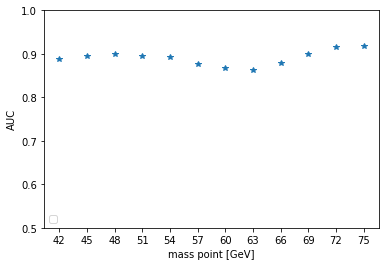

In [24]:
import matplotlib as mpl
#mpl.use('Agg')
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from keras.models import load_model

model = load_model("Below180/models/noptZZ_allp_17f_hM.h5")

## load test (cross validation) data
xb_test = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below180/UnscaledData/test/tree_qqZZ.npy')
bkgset = ['ggZZ', 'ggZZ_low']
for bk in bkgset:
    xb_test_add = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below180/UnscaledData/test/tree_{}.npy'.format(bk))
    xb_test = np.concatenate((xb_test,xb_test_add))

yb_test = np.zeros(len(xb_test))

msamp = [42,45,48,51,54,57,60,63,66,69,72,75]
auc_dm = np.zeros(len(msamp))

for im,mass in enumerate(msamp):
    if mass < 40: nZp = 10
    elif mass > 40: nZp = 9
    xs_test_dm = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below180/UnscaledData/test/tree_{}GeV.npy'.format(mass))
    ys_test_dm = np.ones(len(xs_test_dm))

    xcomb_test_dm = np.concatenate((xs_test_dm, xb_test)) 
    ycomb_test_dm = np.concatenate((ys_test_dm, yb_test))
    xcomb_test_dm[:,0] = xcomb_test_dm[:,nZp]
    wt_test = xcomb_test_dm[:,-1]
    xcomb_test_dm = get_part_feature(xcomb_test_dm)

    predictions_dm = model.predict(xcomb_test_dm)
    # Compare to ground truth and create ROC plot
    fpr_dm, tpr_dm, _ = roc_curve(ycomb_test_dm, predictions_dm, sample_weight=wt_test)
    auc_dm[im] = auc(tpr_dm, fpr_dm)        
    
# Plot AUC
plt.figure(figsize=(6, 4))
plt.plot(1-auc_dm, '*')
plt.xticks(np.arange(12), msamp)
plt.ylim((0.5,1))
plt.xlabel("mass point [GeV]")
plt.ylabel("AUC")
plt.legend(loc=3)
#plt.savefig("/Users/zhuheling/ML/keras/example_hep/myTest/Below120/plots/auc_trainqqpgg_testall.pdf")
plt.show()


### results for training w/o one mass point

In [12]:
import matplotlib as mpl
#mpl.use('Agg')
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
from keras.models import load_model

model = load_model("Below180/models/noptZZ_no69_17f_hM.h5")

## load test (cross validation) data
xb_test = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below180/UnscaledData/test/tree_qqZZ.npy')
bkgset = ['ggZZ', 'ggZZ_low']
for bk in bkgset:
    xb_test_add = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below180/UnscaledData/test/tree_{}.npy'.format(bk))
    xb_test = np.concatenate((xb_test,xb_test_add))
yb_test = np.zeros(len(xb_test))

msamp = [42,45,48,51,54,57,60,63,66,69,72,75]
auc_dm_no69 = np.zeros(len(msamp))

for im,mass in enumerate(msamp):
    if mass < 40: nZp = 10
    elif mass > 40: nZp = 9
    #print("Test mass sample: ", mass, "GeV")
    xs_test_dm = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below180/UnscaledData/test/tree_{}GeV.npy'.format(mass))
    ys_test_dm = np.ones(len(xs_test_dm))
    #print(sum(xs_test_dm[:,-1]))

    #xb_test[:,-1] = norweight(xb_test[:,-1], norm=sum(xs_test_dm[:,-1]))
    xcomb_test_dm = np.concatenate((xs_test_dm, xb_test)) 
    ycomb_test_dm = np.concatenate((ys_test_dm, yb_test))
    # Randomlize the order of training data using split function
    xcomb_test_dm[:,0] = xcomb_test_dm[:,nZp]
    wt_test = xcomb_test_dm[:,-1]
    #print(wt_test[0:20])
    xcomb_test_dm = get_part_feature(xcomb_test_dm)

    predictions_dm = model.predict(xcomb_test_dm)
    # Compare to ground truth and create ROC plot
    fpr_dm, tpr_dm, _ = roc_curve(ycomb_test_dm, predictions_dm, sample_weight=wt_test)
    #print (sum(tpr_dm), len(tpr_dm))
    auc_dm_no69[im] = auc(tpr_dm, fpr_dm)
    # Plot ROC
    #plt.figure(figsize=(4, 4))
    #plt.plot(tpr_dm, 1.0-fpr_dm, lw=3, alpha=0.8)
    #plt.xlabel("Signal efficiency")
    #plt.ylabel("Background rejection")
    #plt.legend(loc=3)
    #plt.xlim((0.0, 1.0))
    #plt.ylim((0.0, 1.0))
    #plt.show()

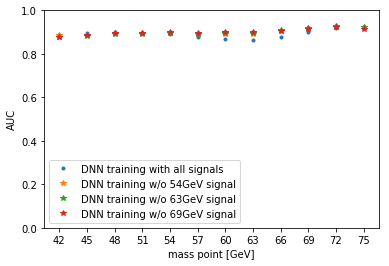

In [28]:
# Plot AUC
plt.figure(figsize=(6, 4))
plt.plot(1-auc_dm, '.', label='DNN training with all signals')
plt.plot(1-auc_dm_no54, '*', label='DNN training w/o 54GeV signal')
plt.plot(1-auc_dm_no63, '*', label='DNN training w/o 63GeV signal')
plt.plot(1-auc_dm_no69, '*', label='DNN training w/o 69GeV signal')
plt.xticks(np.arange(12), msamp)
plt.ylim((0,1))
plt.xlabel("mass point [GeV]")
plt.ylabel("AUC")
plt.legend(loc=3)
plt.savefig("/Users/zhuheling/ML/keras/example_hep/myTest/plots/plots_nopTZZ/hM_auc_no546369.pdf")
plt.show()

# Now let's test the signal and bkg to get the score one by one
## For signal and background prediction separately
## Firstly need to check if over-fitting

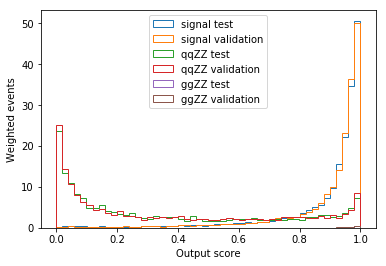

In [8]:
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from keras.models import load_model

model = load_model("Below180/models/noptZZ_17f_hM.h5")
nZp=9

### prepare prediction for signal
xs_test = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below180/UnscaledData/test/tree_{}GeV.npy'.format(42))
xs_val = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below180/UnscaledData/Validation/tree_{}GeV.npy'.format(42))
xs_train = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below180/UnscaledData/train/tree_{}GeV.npy'.format(42))
msamp = [45,48,51,54,57,60,63,66,69,72,75]
for mass in msamp:
    xs_test_add = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below180/UnscaledData/test/tree_{}GeV.npy'.format(mass))
    xs_test = np.concatenate((xs_test, xs_test_add))
    xs_val_add = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below180/UnscaledData/Validation/tree_{}GeV.npy'.format(mass))
    xs_val = np.concatenate((xs_val, xs_val_add))
    xs_train_add = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below180/UnscaledData/train/tree_{}GeV.npy'.format(mass))
    xs_train = np.concatenate((xs_train, xs_train_add))
    
xs_test[:,0] = xs_test[:,nZp]
xs_test_par = get_part_feature(xs_test)
pred_sig_test = model.predict(xs_test_par)
xs_val[:,0] = xs_val[:,nZp]
xs_val_par = get_part_feature(xs_val)
pred_sig_val = model.predict(xs_val_par)
xs_train[:,0] = xs_train[:,nZp]
xs_train_par = get_part_feature(xs_train)
pred_sig_train = model.predict(xs_train_par)

### prepare prediction for background test sample
xb_test = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below180/UnscaledData/test/tree_qqZZ.npy')
xb_test[:,0] = xb_test[:,nZp]
xb_test_par = get_part_feature(xb_test)
pred_bkg_test = model.predict(xb_test_par)

### prepare prediction for background Validation sample
xb_val = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below180/UnscaledData/Validation/tree_qqZZ.npy')
xb_val[:,0] = xb_val[:,nZp]
xb_val_par = get_part_feature(xb_val)
pred_bkg_val = model.predict(xb_val_par)

### prepare prediction for background test sample
xb_train = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below180/UnscaledData/train/tree_qqZZ.npy')
xb_train[:,0] = xb_train[:,nZp]
xb_train_par = get_part_feature(xb_train)
pred_bkg_train = model.predict(xb_train_par)

### prepare prediction for background test sample
x2_test = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below180/UnscaledData/test/tree_ggZZ.npy')
x2_test_add = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below180/UnscaledData/test/tree_ggZZ_low.npy')
x2_test = np.concatenate((x2_test, x2_test_add))
x2_test[:,0] = x2_test[:,nZp]
x2_test_par = get_part_feature(x2_test)
pred_ggZZ_test = model.predict(x2_test_par)

x2_val = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below180/UnscaledData/Validation/tree_ggZZ.npy')
x2_val_add = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below180/UnscaledData/Validation/tree_ggZZ_low.npy')
x2_val = np.concatenate((x2_val, x2_val_add))
x2_val[:,0] = x2_val[:,nZp]
x2_val_par = get_part_feature(x2_val)
pred_ggZZ_val = model.predict(x2_val_par)

#print(len(pred_sig_test), len(xs_test), sum(xs_test[:,-1]))
#print(len(pred_bkg_test), len(xb_test), sum(xb_test[:,-1]))
#print(len(pred_bkg_val), len(xb_val), sum(xb_val[:,-1]))

nbkg = sum(xb_test[:,-1])+sum(x2_test[:,-1])
xs_test[:,-1] = norweight(xs_test[:,-1], norm=nbkg)
xs_val[:,-1] = norweight(xs_val[:,-1], norm=nbkg)

## plot output score
plt.hist(pred_sig_test, bins=50, weights=xs_test[:,-1], histtype='step', label='signal test')
plt.hist(pred_sig_val, bins=50, weights=xs_val[:,-1], histtype='step', label='signal validation')
#plt.hist(pred_sig_train, bins=50, histtype='step', label='signal train', density=True)
plt.hist(pred_bkg_test, bins=50, weights=xb_test[:,-1], histtype='step', label='qqZZ test')
plt.hist(pred_bkg_val, bins=50, weights=xb_val[:,-1], histtype='step', label='qqZZ validation')
#plt.hist(pred_bkg_train, bins=50, histtype='step', label='background train')
plt.hist(pred_ggZZ_test, bins=50, weights=x2_test[:,-1], histtype='step', label='ggZZ test')
plt.hist(pred_ggZZ_val, bins=50, weights=x2_val[:,-1], histtype='step', label='ggZZ validation')
plt.legend(loc=9)
plt.xlabel("Output score")
plt.ylabel("Weighted events")
plt.savefig("/Users/zhuheling/ML/keras/example_hep/myTest/plots/hM_noptZZ_DNNscore.pdf")
plt.show()

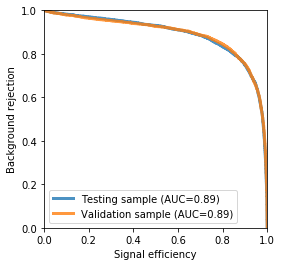

In [21]:
xcomb_test2 = np.concatenate((xs_test_par,xb_test_par))
xcomb_val2 = np.concatenate((xs_val_par,xb_val_par))
xcomb_test2 = np.concatenate((xcomb_test2,x2_test_par))
xcomb_val2 = np.concatenate((xcomb_val2,x2_val_par))

ys_test2 = np.ones(len(xs_test_par))
ys_val2 = np.ones(len(xs_val_par))
yb_test2 = np.zeros(len(xb_test_par))
yb_val2 = np.zeros(len(xb_val_par))
ycomb_test2 = np.concatenate((ys_test2,yb_test2))
ycomb_val2 = np.concatenate((ys_val2,yb_val2))

pred_test = np.concatenate((pred_sig_test,pred_bkg_test))
pred_val = np.concatenate((pred_sig_val,pred_bkg_val))

# Compare to ground truth and create ROC plot
fpr_test, tpr_test, _ = roc_curve(ycomb_test2, pred_test)
auc_test = auc(fpr_test, tpr_test)
fpr_val, tpr_val, _ = roc_curve(ycomb_val2, pred_val)
auc_val = auc(fpr_val, tpr_val)

# Plot ROC
plt.figure(figsize=(4, 4))
plt.plot(tpr_test, 1.0-fpr_test, lw=3, alpha=0.8,
        label="Testing sample (AUC={:.2f})".format(auc_test))
plt.plot(tpr_val, 1.0-fpr_val, lw=3, alpha=0.8,
        label="Validation sample (AUC={:.2f})".format(auc_val))
plt.xlabel("Signal efficiency")
plt.ylabel("Background rejection")
plt.legend(loc=3)
plt.xlim((0.0, 1.0))
plt.ylim((0.0, 1.0))
plt.savefig("/Users/zhuheling/ML/keras/example_hep/myTest/plots/plots_nopTZZ/hM_roc.pdf")
plt.show()

If cut at score >  0.9
Signal efficiency:  0.6948257526118737
Background efficiency:  0.11203137956601521
Significance BEFORE: S/sqrt(B)  1
Significance AFTER: S/sqrt(B)  2.0758982583440617


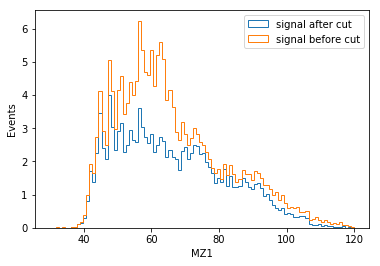

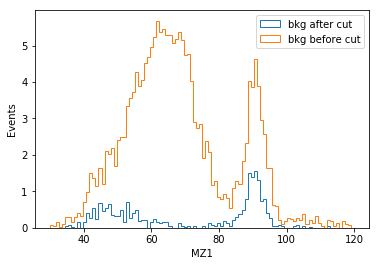

In [22]:
cut = 0.9
print ("If cut at score > ", cut)
## Before cut
all_sig_all=0
all_bkg_all=0
for ie in range(len(xs_test)):
    all_sig_all += xs_test[ie,-1]

for ie in range(len(xb_test)):
    all_bkg_all += xb_test[ie,-1]

sigif_all = all_sig_all/np.sqrt(all_bkg_all)

print ("===========================")

## After cut
n_sig = 0
n_bkg = 0
xs_good = np.empty((0,xs_test.shape[1]))
for ie in range(len(xs_test)):
    if pred_sig_test[ie]>cut:
        n_sig += xs_test[ie,-1]
        xs_good = np.append(xs_good, np.reshape(xs_test[ie],(1,-1)),axis = 0)

xb_good = np.empty((0,xb_test.shape[1]))
for ie in range(len(xb_test)):
    if pred_bkg_test[ie]>cut:
        n_bkg += xb_test[ie,-1]
        xb_good = np.append(xb_good, np.reshape(xb_test[ie],(1,-1)),axis = 0)
#print (len(xb_good))
        
eff_sig = n_sig/all_sig_all
eff_bkg = n_bkg/all_bkg_all
sigif_cut = eff_sig/np.sqrt(eff_bkg)

print ("Signal efficiency: ", eff_sig)
print ("Background efficiency: ", eff_bkg)
print ("Significance BEFORE: S/sqrt(B) ", 1)
print ("Significance AFTER: S/sqrt(B) ", sigif_cut)

## make plots after cut
plt.hist(xs_good[:,9], bins=100, histtype='step', label='signal after cut', range=(30,120), weights=xs_good[:,-1])
plt.hist(xs_test[:,9], bins=100, histtype='step', label='signal before cut', range=(30,120), weights=xs_test[:,-1])
#plt.hist(xs_test[:,9], bins=50, histtype='step', label='signal before cut')
plt.legend(prop={'size': 10})
plt.xlabel("MZ1")
plt.ylabel("Events")
#plt.yscale('log')
#plt.ylim([10e-2,10e2])
plt.savefig("/Users/zhuheling/ML/keras/example_hep/myTest/plots/plots_nopTZZ/hM_sig_mz1.pdf")
plt.show()

plt.hist(xb_good[:,9], bins=100, histtype='step', label='bkg after cut', range=(30,120), weights=xb_good[:,-1])
#plt.hist(xs_good[:,9], bins=50, histtype='step', label='signal after cut', range=(30,120), weights=xs_good[:,-1])
plt.hist(xb_test[:,9], bins=100, histtype='step', label='bkg before cut', range=(30,120), weights=xb_test[:,-1])
#plt.hist(xs_test[:,9], bins=50, histtype='step', label='signal before cut', range=(30,120), weights=xs_test[:,-1])
plt.legend(prop={'size': 10})
plt.xlabel("MZ1")
plt.ylabel("Events")
#plt.yscale('log')
#plt.ylim([10e-2,10e2])
plt.savefig("/Users/zhuheling/ML/keras/example_hep/myTest/plots/plots_nopTZZ/hM_bkg_mz1.pdf")
plt.show()

#plt.hist(xs_good[:,10], bins=50, histtype='step', label='signal after cut', range=(0,60), density=True)
#plt.hist(xb_good[:,10], bins=50, histtype='step', label='bkg after cut', range=(0,60), density=True)
##plt.hist(xs_test[:,10], bins=50, histtype='step', label='signal before cut')
#plt.legend(prop={'size': 10})
#plt.xlabel("MZ2")
#plt.ylabel("A.U.")
#plt.xlim([0,50])
#plt.show()

#plt.hist(xb_good[:,10], bins=50, histtype='step', label='bkg after cut')
#plt.hist(xb_test[:,10], bins=50, histtype='step', label='bkg before cut')
#plt.legend(prop={'size': 10})
#plt.xlabel("MZ2")
#plt.ylabel("Events")
#plt.yscale('log')
#plt.xlim([0,50])
#plt.show()

## Check one mass point each time

Looking at mass:  42 GeV; 5sigma:  3.9057790000000003


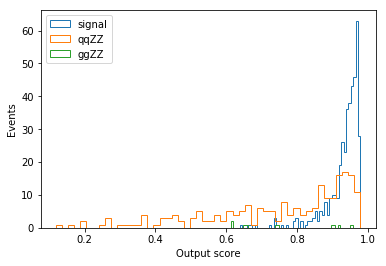

Best cut  0.9
Signal efficiency:  0.8467843141884794
Background efficiency:  0.30837780338213855
Significance BEFORE: S/sqrt(B)  0.9950213852535104
Significance AFTER: S/sqrt(B)  1.5248644839865666
Looking at mass:  45 GeV; 5sigma:  4.192012


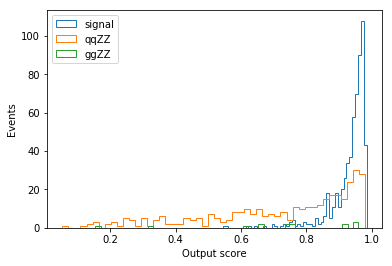

Best cut  0.9
Signal efficiency:  0.8253507324904271
Background efficiency:  0.29484256203466996
Significance BEFORE: S/sqrt(B)  0.9958359956452477
Significance AFTER: S/sqrt(B)  1.5199995272873232
Looking at mass:  51 GeV; 5sigma:  4.764478


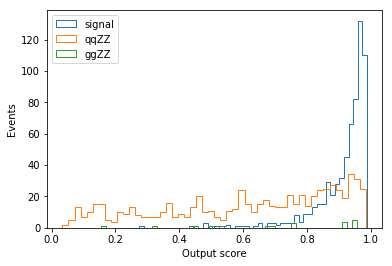

Best cut  0.9
Signal efficiency:  0.7275511087129858
Background efficiency:  0.16467700098086746
Significance BEFORE: S/sqrt(B)  0.9982963071789064
Significance AFTER: S/sqrt(B)  1.7928627012950231
Looking at mass:  54 GeV; 5sigma:  5.050711


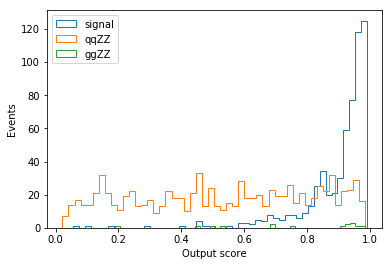

Best cut  0.9
Signal efficiency:  0.679448516228741
Background efficiency:  0.09985841056934065
Significance BEFORE: S/sqrt(B)  1.0079821224912453
Significance AFTER: S/sqrt(B)  2.150127579996301
Looking at mass:  57 GeV; 5sigma:  5.336944


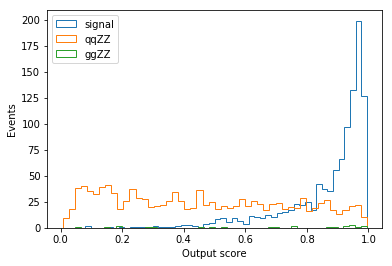

Best cut  0.9
Signal efficiency:  0.6012653085376186
Background efficiency:  0.06360083845386369
Significance BEFORE: S/sqrt(B)  1.027326055258958
Significance AFTER: S/sqrt(B)  2.3841563164684287
Looking at mass:  60 GeV; 5sigma:  5.623177


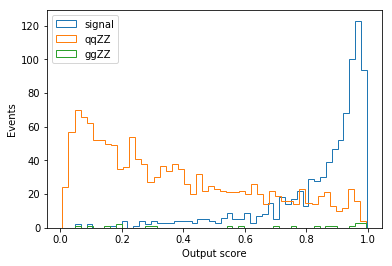

Best cut  0.9
Signal efficiency:  0.5348674234768513
Background efficiency:  0.042547788856021694
Significance BEFORE: S/sqrt(B)  1.0776482999093608
Significance AFTER: S/sqrt(B)  2.5930306484295063
Looking at mass:  63 GeV; 5sigma:  5.90941


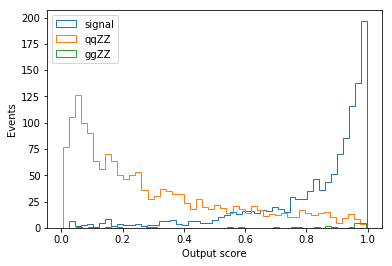

Best cut  0.9
Signal efficiency:  0.5079747363899831
Background efficiency:  0.024617377528496694
Significance BEFORE: S/sqrt(B)  1.2377458402089252
Significance AFTER: S/sqrt(B)  3.237585308388534
Looking at mass:  66 GeV; 5sigma:  6.1956430000000005


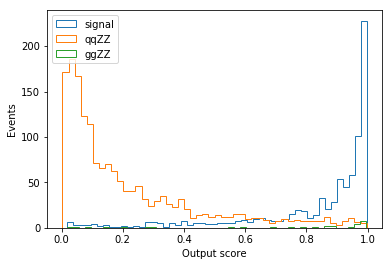

Best cut  0.9
Signal efficiency:  0.5909788078100098
Background efficiency:  0.019088301777332655
Significance BEFORE: S/sqrt(B)  1.6452279833111447
Significance AFTER: S/sqrt(B)  4.277482696634296
Looking at mass:  69 GeV; 5sigma:  6.481876


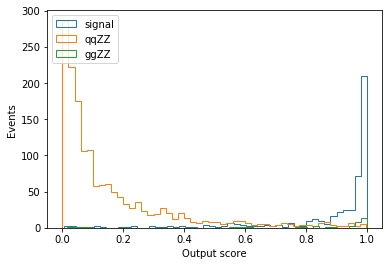

Best cut  0.9
Signal efficiency:  0.7183817088689088
Background efficiency:  0.013603641803184793
Significance BEFORE: S/sqrt(B)  2.7572556538648505
Significance AFTER: S/sqrt(B)  6.159247727775315
Looking at mass:  72 GeV; 5sigma:  6.768109


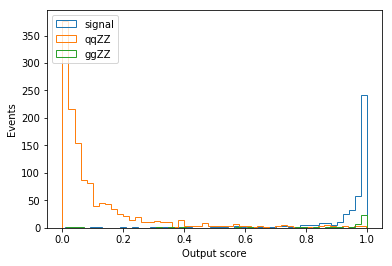

Best cut  0.9
Signal efficiency:  0.8227341994155856
Background efficiency:  0.012319543485448047
Significance BEFORE: S/sqrt(B)  6.9625369751823305
Significance AFTER: S/sqrt(B)  7.412457955613462
Looking at mass:  75 GeV; 5sigma:  7.054342


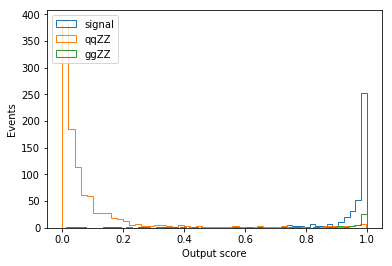

Best cut  0.9
Signal efficiency:  0.8390337614808036
Background efficiency:  0.022255015517647803
Significance BEFORE: S/sqrt(B)  12.444116991587462
Significance AFTER: S/sqrt(B)  5.624261251753124


In [24]:
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from keras.models import load_model

model = load_model("Below180/models/noptZZ_17f_hM.h5")

### prepare prediction for background test sample
xb_test_qqZZ = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below180/UnscaledData/test/tree_qqZZ.npy')
xb_test_ggZZ = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below180/UnscaledData/test/tree_ggZZ.npy')
x2_test_add = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below180/UnscaledData/test/tree_ggZZ_low.npy')
xb_test_ggZZ = np.concatenate((xb_test_ggZZ, x2_test_add))  

### prepare prediction for signal
msamp = [42,45,51,54,57,60,63,66,69,72,75]
#msamp = [72,75]
sigif = np.ones(len(msamp))
s_eff = np.ones(len(msamp))
b_eff = np.ones(len(msamp))
i=0
for mass in msamp:
    print ("=====================================")
    if mass < 40.: nZp = 10
    elif mass > 40.: nZp = 9
    sigma = 5*(-0.0202966+0.0190822*mass)
    print ("Looking at mass: ", mass, "GeV; 5sigma: ", sigma)    
    xs_test = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below180/UnscaledData/test/tree_{}GeV.npy'.format(mass))
    xs_test[:,0] = xs_test[:,nZp]

    xb_test_qqZZ[:,0] = xb_test_qqZZ[:,nZp]
    xb_test_ggZZ[:,0] = xb_test_ggZZ[:,nZp]

    ## Before cut
    all_sig_lM=0
    all_bkg_lM=0
    all_sig=0
    all_bkg=0
    xs_region = np.empty((0,xs_test.shape[1]))
    xb_region_qqZZ = np.empty((0,xb_test_qqZZ.shape[1]))
    xb_region_ggZZ = np.empty((0,xb_test_ggZZ.shape[1]))
    for ie in range(len(xs_test)):
        if xs_test[ie,nZp] < mass+sigma and xs_test[ie,nZp] > mass-sigma:# and xs_test[ie,14]<120.:
            xs_region = np.append(xs_region, np.reshape(xs_test[ie],(1,-1)),axis = 0)
            all_sig += xs_test[ie,-1]
            if xs_test[ie,14]<120.: all_sig_lM += xs_test[ie,-1]

    for ie in range(len(xb_test_qqZZ)):
        if xb_test_qqZZ[ie,nZp] < mass+sigma and xb_test_qqZZ[ie,nZp] > mass-sigma:# and xb_test_qqZZ[ie,14]<120.:
            xb_region_qqZZ = np.append(xb_region_qqZZ, np.reshape(xb_test_qqZZ[ie],(1,-1)),axis = 0)
            all_bkg += xb_test_qqZZ[ie,-1]
            if xb_test_qqZZ[ie,14]<120.: all_bkg_lM += xb_test_qqZZ[ie,-1]

    for ie in range(len(xb_test_ggZZ)):
        if xb_test_ggZZ[ie,nZp] < mass+sigma and xb_test_ggZZ[ie,nZp] > mass-sigma:# and xb_test_ggZZ[ie,14]<120.:
            xb_region_ggZZ = np.append(xb_region_ggZZ, np.reshape(xb_test_ggZZ[ie],(1,-1)),axis = 0)
            all_bkg += xb_test_ggZZ[ie,-1]
            if xb_test_ggZZ[ie,14]<120.: all_bkg_lM += xb_test_ggZZ[ie,-1]

    eff1_sig=all_sig/all_sig_lM
    eff1_bkg=all_bkg/all_bkg_lM
    sigif_all = eff1_sig/np.sqrt(eff1_bkg)
    #print("Events in mass window before DNN cut: signal/bkg", len(xs_region), len(xb_region)
    xs_reg_par = get_part_feature(xs_region)
    pred_sig_reg = model.predict(xs_reg_par)
    xb_qqZZ_par = get_part_feature(xb_region_qqZZ)
    pred_qqZZ_reg = model.predict(xb_qqZZ_par)
    xb_ggZZ_par = get_part_feature(xb_region_ggZZ)
    pred_ggZZ_reg = model.predict(xb_ggZZ_par)
    
    ## plot output score
    plt.hist(pred_sig_reg, bins=50, histtype='step', label='signal')
    plt.hist(pred_qqZZ_reg, bins=50, histtype='step', label='qqZZ')
    plt.hist(pred_ggZZ_reg, bins=50, histtype='step', label='ggZZ')
    plt.legend(loc=2)
    plt.xlabel("Output score")
    plt.ylabel("Events")
    #plt.xlim([0,1.])
    plt.show()
    
    ## After cut
    max_signif = -1.
    ## Do scan of cut
    for ic in range(20):
        #cut = ic*0.05
        cut = 0.9
        n_sig = 0
        n_bkg = 0
        for ie in range(len(xs_region)):
            if pred_sig_reg[ie]>cut: n_sig += xs_region[ie,-1]
        for ie in range(len(xb_region_qqZZ)):
            if pred_qqZZ_reg[ie]>cut: n_bkg += xb_region_qqZZ[ie,-1]
        for ie in range(len(xb_region_ggZZ)):
            if pred_ggZZ_reg[ie]>cut: n_bkg += xb_region_ggZZ[ie,-1]

        s_eff[i] = n_sig/all_sig
        b_eff[i] = n_bkg/all_bkg
        sigif_cut = s_eff[i]/np.sqrt(b_eff[i])
        if sigif_cut > max_signif:
            eff_sig = s_eff[i]
            eff_bkg = b_eff[i]
            max_signif = sigif_cut
            mCut = cut
            break

    print ("Best cut ", mCut)
    print ("Signal efficiency: ", eff_sig)
    print ("Background efficiency: ", eff_bkg)
    print ("Significance BEFORE: S/sqrt(B) ", sigif_all)
    print ("Significance AFTER: S/sqrt(B) ", max_signif)
    
    ## save significance
    sigif[i] = max_signif
    i+=1

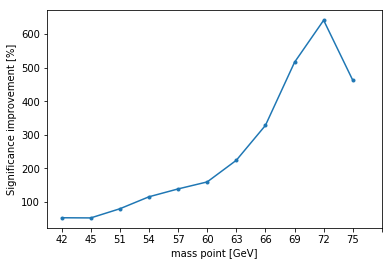

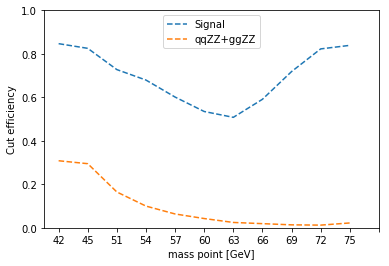

In [27]:
## plot significance of each point
plt.plot((sigif-1)*100,'.-', label='Train with signal mass > 40GeV')
#plt.plot(sigif2,'*', label='Train with all 19 signals')
plt.xticks(np.arange(12), msamp)
plt.xlabel("mass point [GeV]")
plt.ylabel("Significance improvement [%]")
#plt.yscale('log')
#plt.legend(loc=2)
plt.savefig("/Users/zhuheling/ML/keras/example_hep/myTest/plots/plots_nopTZZ/hM_significance_dnn0p9.pdf")
plt.show()

plt.plot(s_eff,'--', label='Signal')
plt.plot(b_eff,'--', label='qqZZ+ggZZ')
plt.xticks(np.arange(12), msamp)
plt.xlabel("mass point [GeV]")
plt.ylabel("Cut efficiency")
plt.ylim([0,1])
plt.legend(loc=9)
plt.savefig("/Users/zhuheling/ML/keras/example_hep/myTest/plots/plots_nopTZZ/hM_eff_dnn0p9.pdf")
plt.show()

# Systematics test
## for signal

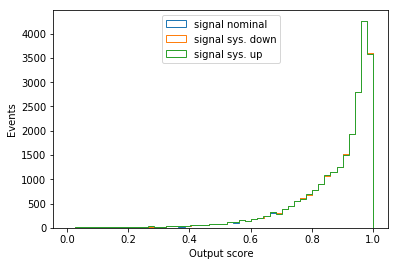

In [16]:
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from keras.models import load_model

model = load_model("Below180/models/all2_18features_hM.h5")
nZp=10

### prepare prediction for signal
xs_test = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below180/UnscaledData/test/tree_{}GeV.npy'.format(42))
xs_sysdo = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below180/sysData_down/test/tree_{}GeV.npy'.format(42))
xs_sysup = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below180/sysData_up/test/tree_{}GeV.npy'.format(42))
msamp = [45,48,51,54,57,60,63,66,69,72,75]
for mass in msamp:
    xs_test_add = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below180/UnscaledData/test/tree_{}GeV.npy'.format(mass))
    xs_test = np.concatenate((xs_test, xs_test_add))
    xs_sysdo_add = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below180/sysData_down/test/tree_{}GeV.npy'.format(mass))
    xs_sysdo = np.concatenate((xs_sysdo, xs_sysdo_add))

    xs_sysup_add = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below180/sysData_up/test/tree_{}GeV.npy'.format(mass))
    xs_sysup = np.concatenate((xs_sysup, xs_sysup_add))

xs_test[:,0] = xs_test[:,nZp]
xs_test_par = get_part_feature(xs_test)
pred_sig_test = model.predict(xs_test_par)

xs_sysdo[:,0] = xs_sysdo[:,nZp]
xs_sysdo_par = get_part_feature(xs_sysdo)
pred_sig_sysdo = model.predict(xs_sysdo_par)

xs_sysup[:,0] = xs_sysup[:,nZp]
xs_sysup_par = get_part_feature(xs_sysup)
pred_sig_sysup = model.predict(xs_sysup_par)

## plot output score
plt.hist(pred_sig_test, bins=50, histtype='step', label='signal nominal')
plt.hist(pred_sig_sysdo , bins=50, histtype='step', label='signal sys. down')
plt.hist(pred_sig_sysup , bins=50, histtype='step', label='signal sys. up')
plt.legend(loc=9)
plt.xlabel("Output score")
plt.ylabel("Events")
plt.show()

## for background

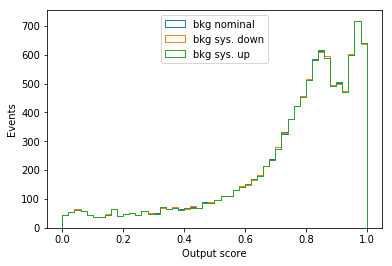

In [17]:
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from keras.models import load_model

model = load_model("Below180/models/SGD/baseline_18features.h5")
nZp=10

### prepare prediction for background test sample
xb_test = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below180/UnscaledData/test/tree_qqZZ.npy')
xb_test[:,0] = xb_test[:,nZp]
xb_test_par = get_part_feature(xb_test)
pred_bkg_test = model.predict(xb_test_par)

xb_sysdo = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below180/sysData_down/test/tree_qqZZ.npy')
xb_sysdo[:,0] = xb_sysdo[:,nZp]
xb_sysdo_par = get_part_feature(xb_sysdo)
pred_bkg_sysdo = model.predict(xb_sysdo_par)

xb_sysup = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below180/sysData_up/test/tree_qqZZ.npy')
xb_sysup[:,0] = xb_sysup[:,nZp]
xb_sysup_par = get_part_feature(xb_sysup)
pred_bkg_sysup = model.predict(xb_sysup_par)

## plot output score
plt.hist(pred_bkg_test, bins=50, histtype='step', label='bkg nominal')
plt.hist(pred_bkg_sysdo, bins=50, histtype='step', label='bkg sys. down')
plt.hist(pred_bkg_sysup, bins=50, histtype='step', label='bkg sys. up')
plt.legend(loc=9)
plt.xlabel("Output score")
plt.ylabel("Events")
plt.show()

# Check the weight of each feature
## Load test datasets

In [16]:
xs_test = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below180/UnscaledData/test/tree_{}GeV.npy'.format(45))
#msamp2 = [7,9,11,13,15,17,19,23,27,31,35,39]
msamp2 = [51,57,63,69,75]
nZp=9
for mass in msamp2:
    xs_test_add = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below180/UnscaledData/test/tree_{}GeV.npy'.format(mass))
    xs_test = np.concatenate((xs_test,xs_test_add))

xb_test = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below180/UnscaledData/test/tree_qqZZ.npy')
bkgset = ['ggZZ', 'ggZZ_low']
for bk in bkgset:
    xb_test_add = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below180/UnscaledData/test/tree_{}.npy'.format(bk))
    xb_test = np.concatenate((xb_test,xb_test_add))   

xs_test[:,0] = xs_test[:,nZp]
xb_test[:,0] = xb_test[:,nZp]
ys_test = np.ones(len(xs_test))
yb_test = np.zeros(len(xb_test))
xcomb_test = np.concatenate((xs_test, xb_test))
ycomb_test = np.concatenate((ys_test, yb_test))

# Define the weight and features for training
#ycomb_test = ycomb_test[(xcomb_test[:,0]>69.-5.) & (xcomb_test[:,0]<69.+5.)]
#xcomb_test = xcomb_test[(xcomb_test[:,0]>69.-5.) & (xcomb_test[:,0]<69.+5.)]
wt_test = xcomb_test[:,-1]
xcomb_test = get_part_feature(xcomb_test)

print ("Testing data shape:", xcomb_test.shape, wt_test.shape)

#from keras.models import load_model
#import matplotlib.pyplot as plt

#model = load_model("Below180/models/SGD/qqpggZZ_18features.h5")

#pred_sig_1 = model.predict(get_part_feature(xs_test))
#pred_bkg_1 = model.predict(get_part_feature(xb_test))
#xs_test[:,0] = 69
#xb_test[:,0] = 69
#pred_sig_2 = model.predict(get_part_feature(xs_test))
#pred_bkg_2 = model.predict(get_part_feature(xb_test))
#plt.hist(pred_sig_1, bins=50, histtype='step', label='Signal real MZ1', weights=xs_test[:,-1])
#plt.hist(pred_bkg_1, bins=50, histtype='step', label='Bkg real MZ1', weights=xb_test[:,-1])
#plt.hist(pred_sig_2, bins=50, histtype='step', label='Signal mass 69', weights=xs_test[:,-1])
#plt.hist(pred_bkg_2, bins=50, histtype='step', label='Bkg mass 69', weights=xb_test[:,-1])
#plt.legend(loc=9)
#plt.xlabel("Output score")
#plt.ylabel("Events")
#plt.show()


Testing data shape: (12236, 18) (12236,)


In [17]:
import eli5
from eli5.sklearn import PermutationImportance
from keras.models import load_model
from math import sqrt,log

model = load_model("Below180/models/SGD/test2_rnn_mlp_hM.h5")

def amsasimov(s,b):
    if b<=0 or s<=0:
        return 0
    try:
        return (float(s)/sqrt(b))
    except ValueError:
        print(1+float(s)/b)
        print(float(s)/sqrt(b))
        
# If you are not using Keras Sequential, you might not be able to use predict_proba 
# so we define a new function using predict to calculate the significance:
def Significance_keras(estimator, X, Y):
    y_pred = estimator.predict(X)
    y_pred = y_pred.ravel()
    int_pred_test_sig = [wt_test[(Y == 1) & (y_pred > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]
    int_pred_test_bkg = [wt_test[(Y == 0) & (y_pred > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]
    vamsasimov = [amsasimov(sumsig,sumbkg) for (sumsig,sumbkg) in zip(int_pred_test_sig,int_pred_test_bkg)]
    significance = max(vamsasimov)
    Z = significance
    return Z        

perm_test = PermutationImportance(model, scoring=Significance_keras).fit(xcomb_test, ycomb_test, sample_weight=wt_test)


In [18]:
from IPython.display import display
import numpy as np

features = np.array(['mass_parameter', ## 0
            'PtL1',       ## 1
            'PtL2',       ## 2
            'PtL3',       ## 3
            'PtL4',       ## 4
            'EtaL1',      ## 5
            'EtaL2',      ## 6
            'EtaL3',      ## 7
            'EtaL4',      ## 8
            'MZ1_MZ2',    ## 9
            'PtZ1',       ## 10
            'PtZ2',       ## 11
            'MZZ',        ## 12
            'PtZZ',       ## 13
            'DeltaRl12',  ## 14
            'DeltaRl34',  ## 15
            'dEtal12',    ## 16
            'dEtal34'])    ## 17
display(eli5.show_weights(perm_test, feature_names=features))

Weight,Feature
486.5398 ± 13.4895,mass_parameter
467.0936 ± 12.8803,MZ1_MZ2
449.0266 ± 41.8565,MZZ
287.8123 ± 9.3726,PtL4
203.1386 ± 23.8785,PtZ2
153.3192 ± 29.3297,PtZ1
134.5375 ± 11.8654,PtZZ
18.2090 ± 7.6084,PtL3
16.8259 ± 14.4072,PtL2
5.1913 ± 4.6826,EtaL3


In [31]:
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from keras.models import load_model

import eli5
from eli5.sklearn import PermutationImportance
from math import sqrt,log
from IPython.display import display

features = np.array(['mass_parameter', ## 0
            'PtL1',       ## 1
            'PtL2',       ## 2
            'PtL3',       ## 3
            'PtL4',       ## 4
            'EtaL1',      ## 5
            'EtaL2',      ## 6
            'EtaL3',      ## 7
            'EtaL4',      ## 8
            'MZ1_MZ2',    ## 9
            'PtZ1',       ## 10
            'PtZ2',       ## 11
            'MZZ',        ## 12
            'PtZZ',       ## 13
            'DeltaRl12',  ## 14
            'DeltaRl34',  ## 15
            'dEtal12',    ## 16
            'dEtal34'])    ## 17

def amsasimov(s,b):
    if b<=0 or s<=0:
        return 0
    try:
        return (float(s)/sqrt(b))
    except ValueError:
        print(1+float(s)/b)
        print(float(s)/sqrt(b))
        
# If you are not using Keras Sequential, you might not be able to use predict_proba 
# so we define a new function using predict to calculate the significance:
def Significance_keras(estimator, X, Y):
    y_pred = estimator.predict(X)
    y_pred = y_pred.ravel()
    int_pred_test_sig = [wt_test[(Y == 1) & (y_pred > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]
    int_pred_test_bkg = [wt_test[(Y == 0) & (y_pred > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]
    vamsasimov = [amsasimov(sumsig,sumbkg) for (sumsig,sumbkg) in zip(int_pred_test_sig,int_pred_test_bkg)]
    significance = max(vamsasimov)
    Z = significance
    return Z 

model = load_model("Below180/models/SGD/qqpggZZ_18features.h5")

xb_test_all = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below180/UnscaledData/test/tree_bkg.npy')
bkgset = ['ggZZ', 'ggZZ_low']
for bk in bkgset:
    xb_test_add = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below180/UnscaledData/test/tree_{}.npy'.format(bk))
    xb_test_all = np.concatenate((xb_test_all, xb_test_add)) 

### prepare prediction for signal
msamp = [9,39,45,69]
sigif = np.ones(len(msamp))
i=0
for mass in msamp:
    print ("=====================================")
    if mass < 40.: nZp = 10
    elif mass > 40.: nZp = 9
    sigma = 5*(-0.0202966+0.0190822*mass)
    print ("Looking at mass: ", mass, "GeV; 5sigma: ", sigma)    
    xs_test = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below180/UnscaledData/test/tree_{}GeV.npy'.format(mass))
    xs_test[:,0] = xs_test[:,nZp]
    xb_test = xb_test_all
    xb_test[:,0] = xb_test[:,nZp]
    
    xs_test = xs_test[(xs_test[:,0]>mass-sigma) & (xs_test[:,0]<mass+sigma)]
    xb_test = xb_test[(xb_test[:,0]>mass-sigma) & (xb_test[:,0]<mass+sigma)]
    ys_test = np.ones(len(xs_test))
    yb_test = np.zeros(len(xb_test))
    xcomb_test = np.concatenate((xs_test, xb_test))
    ycomb_test = np.concatenate((ys_test, yb_test))
    wt_test = xcomb_test[:,-1]
    xcomb_test = get_part_feature(xcomb_test)

    print ("Testing data shape:", xcomb_test.shape, wt_test.shape, ycomb_test.shape)
    
    perm_test = PermutationImportance(model, scoring=Significance_keras).fit(xcomb_test, ycomb_test, sample_weight=wt_test)
    display(eli5.show_weights(perm_test, feature_names=features))

Looking at mass:  9 GeV; 5sigma:  0.757216
Testing data shape: (2173, 18) (2173,) (2173,)


Weight,Feature
9.1762 ± 0.0000,PtZZ
9.1762 ± 0.0000,PtZ2
9.1542 ± 0.2649,MZ1_MZ2
8.8567 ± 0.1117,PtZ1
8.8450 ± 0.6403,MZZ
6.0399 ± 2.2017,PtL3
4.5037 ± 0.7915,PtL4
2.8843 ± 3.0350,PtL1
0.5135 ± 1.9679,PtL2
0.4058 ± 0.4033,DeltaRl12


Looking at mass:  39 GeV; 5sigma:  3.619546
Testing data shape: (1021, 18) (1021,) (1021,)


Weight,Feature
20.9714 ± 0.0000,MZ1_MZ2
20.7330 ± 0.1691,PtL1
20.1099 ± 2.4070,MZZ
15.5073 ± 6.4854,PtZ1
15.0301 ± 6.4178,PtZZ
6.9761 ± 4.7159,PtL3
3.9378 ± 1.8753,DeltaRl34
3.1715 ± 4.8704,PtZ2
1.6923 ± 7.4789,PtL2
1.6846 ± 1.8828,EtaL2


Looking at mass:  45 GeV; 5sigma:  4.192012
Testing data shape: (1633, 18) (1633,) (1633,)


Weight,Feature
84.5448 ± 0.0000,MZ1_MZ2
31.9422 ± 7.1752,PtZ1
25.0537 ± 15.4596,PtZ2
17.0934 ± 4.0131,PtZZ
12.0184 ± 11.5766,mass_parameter
8.7872 ± 6.2380,PtL1
7.3777 ± 3.9616,PtL3
5.1816 ± 3.0599,PtL4
4.7925 ± 3.3941,DeltaRl34
1.7798 ± 7.8223,MZZ


Looking at mass:  69 GeV; 5sigma:  6.481876
Testing data shape: (3485, 18) (3485,) (3485,)


Weight,Feature
157.4249 ± 48.6082,MZZ
89.3700 ± 6.8887,PtL4
82.7254 ± 235.1419,MZ1_MZ2
48.2792 ± 10.6679,PtZ2
29.0814 ± 32.7028,mass_parameter
22.1990 ± 27.7628,PtZ1
16.0792 ± 11.3925,DeltaRl34
11.0762 ± 27.9542,PtZZ
9.0863 ± 14.4590,PtL2
8.4743 ± 5.7475,PtL3


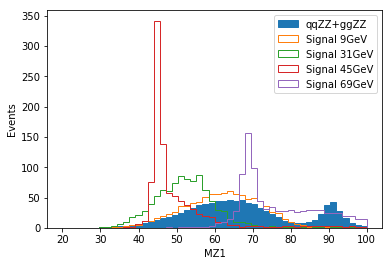

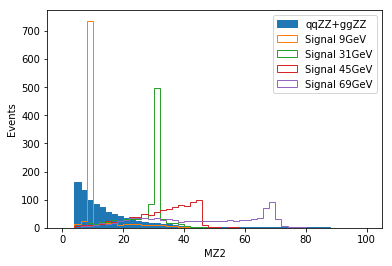

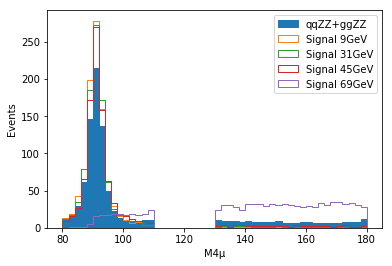

In [14]:
import matplotlib.pyplot as plt

xb_all = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below180/UnscaledData/data_npy/tree_qqZZ.npy')
bkgset = ['ggZZ', 'ggZZ_low']
for bk in bkgset:
    xb_add = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below180/UnscaledData/data_npy/tree_{}.npy'.format(bk))
    xb_all = np.concatenate((xb_all, xb_add)) 

xs_9 = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below180/UnscaledData/data_npy/tree_9GeV.npy')
xs_9[:,-1] = norweight(xs_9[:,-1], norm=sum(xb_all[:,-1]))
xs_31 = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below180/UnscaledData/data_npy/tree_31GeV.npy')
xs_31[:,-1] = norweight(xs_31[:,-1], norm=sum(xb_all[:,-1]))
xs_45 = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below180/UnscaledData/data_npy/tree_45GeV.npy')
xs_45[:,-1] = norweight(xs_45[:,-1], norm=sum(xb_all[:,-1]))
xs_69 = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below180/UnscaledData/data_npy/tree_69GeV.npy')
xs_69[:,-1] = norweight(xs_69[:,-1], norm=sum(xb_all[:,-1]))

plt.hist(xb_all[:,9], bins=50, weights=xb_all[:,-1], histtype='step', label='qqZZ+ggZZ', range=(20,100), fill=True)
plt.hist(xs_9[:,9], bins=50, weights=xs_9[:,-1], histtype='step', label='Signal 9GeV', range=(20,100))
plt.hist(xs_31[:,9], bins=50, weights=xs_31[:,-1], histtype='step', label='Signal 31GeV', range=(20,100))
plt.hist(xs_45[:,9], bins=50, weights=xs_45[:,-1], histtype='step', label='Signal 45GeV', range=(20,100))
plt.hist(xs_69[:,9], bins=50, weights=xs_69[:,-1], histtype='step', label='Signal 69GeV', range=(20,100))
plt.legend(prop={'size': 10})
plt.xlabel("MZ1")
plt.ylabel("Events")
plt.savefig("/Users/zhuheling/ML/keras/example_hep/myTest/Below180/plots/data_npy/MZ1.pdf", format='pdf')
plt.show()

plt.hist(xb_all[:,10], bins=50, weights=xb_all[:,-1], histtype='step', label='qqZZ+ggZZ', range=(0,100), fill=True)
plt.hist(xs_9[:,10], bins=50, weights=xs_9[:,-1], histtype='step', label='Signal 9GeV', range=(0,100))
plt.hist(xs_31[:,10], bins=50, weights=xs_31[:,-1], histtype='step', label='Signal 31GeV', range=(0,100))
plt.hist(xs_45[:,10], bins=50, weights=xs_45[:,-1], histtype='step', label='Signal 45GeV', range=(0,100))
plt.hist(xs_69[:,10], bins=50, weights=xs_69[:,-1], histtype='step', label='Signal 69GeV', range=(0,100))
plt.legend(prop={'size': 10})
plt.xlabel("MZ2")
plt.ylabel("Events")
plt.savefig("/Users/zhuheling/ML/keras/example_hep/myTest/Below180/plots/data_npy/MZ2.pdf", format='pdf')
plt.show()

plt.hist(xb_all[:,14], bins=50, weights=xb_all[:,-1], histtype='step', label='qqZZ+ggZZ', range=(80,180), fill=True)
plt.hist(xs_9[:,14], bins=50, weights=xs_9[:,-1], histtype='step', label='Signal 9GeV', range=(80,180))
plt.hist(xs_31[:,14], bins=50, weights=xs_31[:,-1], histtype='step', label='Signal 31GeV', range=(80,180))
plt.hist(xs_45[:,14], bins=50, weights=xs_45[:,-1], histtype='step', label='Signal 45GeV', range=(80,180))
plt.hist(xs_69[:,14], bins=50, weights=xs_69[:,-1], histtype='step', label='Signal 69GeV', range=(80,180))
plt.legend(prop={'size': 10})
plt.xlabel("M4μ")
plt.ylabel("Events")
plt.savefig("/Users/zhuheling/ML/keras/example_hep/myTest/Below180/plots/data_npy/MZZ.pdf", format='pdf')
plt.show()
